# DNN based Wind Power Forecasting

In [ ]:
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.vector_ar.var_model import VAR
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [ ]:
def custom_date_parser(x): return datetime.strptime(x, "%Y %m %d %H")

def load_data(col=None, path="MUP_dataset.csv", verbose=False):

    dataset = pd.read_csv('MUP_dataset.csv', header=12)
    
    if col is not None:
        dataset = dataset[col]
    if verbose:
        print(dataset.head())
    return dataset

In [ ]:
print("Multivariate Sample")
multivar_df = load_data(
    ['HR','PS', 'WS50M', 'WS10M', 'T2M'], verbose=True)
print(multivar_df.columns[1:2])

Multivariate Sample
   HR     PS  WS50M  WS10M    T2M
0   5  98.49   6.54   3.38  18.79
1   6  98.57   5.91   3.48  19.26
2   7  98.66   5.74   4.70  21.07
3   8  98.72   7.67   6.18  22.94
4   9  98.72   8.40   6.94  24.27
Index(['PS'], dtype='object')


In [ ]:
def correlation_plot(df):
    corr=df.corr()
    corr.style.background_gradient(cmap='coolwarm')

def actual_predicted_plot(actual,predicted,xlabel = 'Time in Hours',ylabel='Wind Speed'):
    plt.figure(figsize=(16,9))
    plt.title('Actual Vs Predicted')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.plot(actual)
    plt.plot(predicted)
    plt.legend(('Actual','predicted'))

def month_wise_plot(df,target_col):
    fig, axs = plt.subplots(figsize=(12, 4))
    df.groupby(df.index.month)[
        'WindSpeed 50'].mean().plot(kind='bar', rot=0, ax=axs)
    plt.xlabel("Months")
    plt.ylabel(target_col)
    plt.show()

def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

def split_data(series,train_freq,test_len=8760,enable_test=False):

    test_slice = len(series)-test_len
    test_data = series[test_slice:]
    if enable_test:
        train_val_data = series[:test_slice]
    else:
        train_val_data = series

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_freq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    return train_data, val_data, test_data


In [ ]:
multivar_df = clean_data(multivar_df)
multivar_df_scaled = min_max_scale(multivar_df)
train_multi, val_multi, test_multi = split_data(multivar_df_scaled, train_freq=0.65, test_len=8760)
print("Multivarate Datasets")
print(f"Dataset Shape: {multivar_df_scaled.shape}")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")


Multivarate Datasets
Dataset Shape: (52608, 5)
Train Data Shape: (34195, 5)
Val Data Shape: (18413, 5)
Test Data Shape: (8760, 5)


In [ ]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False):
    """ Create a windowed tensorflow dataset
    
    """
    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon

    ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:,1:2]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

# tf.random.set_seed(42)

n_steps = 72
n_horizon = 24
batch_size = 1
shuffle_buffer = 100


ds = window_dataset(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)

print('Example sample shapes')
for idx,(x,y) in enumerate(ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Example sample shapes
x =  (1, 72, 5)
y =  (1, 24, 1)


In [ ]:
def build_dataset(train_freq=0.7, 
                  n_steps=24*30, 
                  n_horizon=24, 
                  batch_size=100,
                  shuffle_buffer=500,
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    # tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(col=['HR','PS', 'WS50M', 'WS10M', 'T2M'])
    else:
        data = load_data(col=['WS50M'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_freq=train_freq, test_len=8760,enable_test=False)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = build_dataset(multi_var=True)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


In [ ]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=24*30
    n_horizon=24
    if multivar:
        n_features=multivar_df.shape[1]
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds


### Dense NN model

In [ ]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss=loss, optimizer='adam', metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])

    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()


Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 128)               460928    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 480,536
Trainable params: 480,536
Non-trainable p

### CNN model

In [ ]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 11328)             0         
                                                                 
 dropout (Dropout)           (None, 11328)             0       

### LSTM model

In [ ]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='stacked_lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "stacked_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 72)           22464     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)               

### CNN-LSTM model

In [ ]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 177, 72)           39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

### CNN-LSTM skip model

In [ ]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 720, 5)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 715, 64)      1984        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 357, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 355, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                          

### Vanilla LSTM

In [ ]:
def vanilla_lstm_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential(
    [   
        tf.keras.layers.LSTM(200,input_shape =(n_steps,n_features)),
        tf.keras.layers.Dense(48, activation="sigmoid"),
        tf.keras.layers.Dense(48, activation="tanh"),
        tf.keras.layers.Dense(24, activation="sigmoid"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(units=n_horizon),
    ],)
        
    loss = tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae',tf.keras.metrics.RootMeanSquaredError()])
    
    return model
vanilla_lstm = vanilla_lstm_model(*get_params(multivar=True))
vanilla_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               164800    
                                                                 
 dense (Dense)               (None, 48)                9648      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 24)                1176      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
Total params: 178,576
Trainable params: 178,576
Non-trai

### ARIMA

In [ ]:
def arima_model():
    data = load_data(col=['HR','PS', 'WS50M', 'WS10M', 'T2M'])
    data = clean_data(data)
    mm = MinMaxScaler()
    data = mm.fit_transform(data)
    train_data, val_data, _ = split_data(data, train_freq=0.80, test_len=8760,enable_test=False)
    model = VAR(endog=train_data)
    model_fit = model.fit()

    # make prediction on validation
    prediction = model_fit.forecast(model_fit.endog, steps=48)
    #converting predictions to dataframe
    pred = pd.DataFrame(index=range(0,len(prediction)),columns=['HR','PS', 'WS50M', 'WS10M', 'T2M'])
    for j in range(0,5):
        for i in range(0, len(prediction)):
            pred.iloc[i][j] = prediction[i][j]

    val = pd.DataFrame(val_data,columns=['HR','PS', 'WS50M', 'WS10M', 'T2M'])
    #check rmse
    for i in ['HR','PS', 'WS50M', 'WS10M', 'T2M']:
        print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], val[i])))
        actual_predicted_plot(pred[i][:48], val[i][:48],'Hours','WindSpeed 50')

    

In [ ]:
run_model("dnn", dnn_model, model_configs, epochs=10)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10
16/16 [==============================] - 8s 351ms/step - loss: 0.1414 - mae: 0.4347 - root_mean_squared_error: 0.5456 - val_loss: 0.0347 - val_mae: 0.2107 - val_root_mean_squared_error: 0.2635
Epoch 2/10
16/16 [==============================] - 4s 177ms/step - loss: 0.0439 - mae: 0.2399 - root_mean_squared_error: 0.2962 - val_loss: 0.0149 - val_mae: 0.1418 - val_root_mean_squared_error: 0.1725
Epoch 3/10
16/16 [==============================] - 4s 201ms/step - loss: 0.0265 - mae: 0.1850 - root_mean_squared_error: 0.2303 - val_loss: 0.0150 - val_mae: 0.1410 - val_root_mean_squared_error: 0.1732
Epoch 4/10
16/16 [==============================] - 4s 185ms/step - loss: 0.0207 - mae: 0.1619 - root_mean_squared_error: 0.2032 - val_loss: 0.0296 - val_mae: 0.20

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [ ]:
run_model("cnn", cnn_model, model_configs, epochs=10)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10
16/16 [==============================] - 14s 735ms/step - loss: 0.1331 - mae: 0.3934 - root_mean_squared_error: 0.5500 - val_loss: 0.0172 - val_mae: 0.1550 - val_root_mean_squared_error: 0.1856
Epoch 2/10
16/16 [==============================] - 11s 644ms/step - loss: 0.0203 - mae: 0.1610 - root_mean_squared_error: 0.2015 - val_loss: 0.0148 - val_mae: 0.1406 - val_root_mean_squared_error: 0.1721
Epoch 3/10
16/16 [==============================] - 11s 593ms/step - loss: 0.0144 - mae: 0.1343 - root_mean_squared_error: 0.1698 - val_loss: 0.0131 - val_mae: 0.1313 - val_root_mean_squared_error: 0.1616
Epoch 4/10
16/16 [==============================] - 11s 607ms/step - loss: 0.0121 - mae: 0.1227 - root_mean_squared_error: 0.1554 - val_loss: 0.0146 - val_mae: 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [ ]:
run_model("vanilla_lstm", vanilla_lstm_model, model_configs, epochs=10)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10
16/16 [==============================] - 118s 7s/step - loss: 0.2287 - mae: 0.5590 - root_mean_squared_error: 0.6915 - val_loss: 0.0751 - val_mae: 0.3164 - val_root_mean_squared_error: 0.3876
Epoch 2/10
16/16 [==============================] - 107s 7s/step - loss: 0.0935 - mae: 0.3474 - root_mean_squared_error: 0.4331 - val_loss: 0.0320 - val_mae: 0.2071 - val_root_mean_squared_error: 0.2531
Epoch 3/10
16/16 [==============================] - 105s 7s/step - loss: 0.0566 - mae: 0.2694 - root_mean_squared_error: 0.3365 - val_loss: 0.0187 - val_mae: 0.1569 - val_root_mean_squared_error: 0.1936
Epoch 4/10
16/16 [==============================] - 106s 7s/step - loss: 0.0412 - mae: 0.2272 - root_mean_squared_error: 0.2869 - val_loss: 0.0133 - val_mae: 0.1325 -

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [ ]:
run_model("stacked_lstm", lstm_model, model_configs, epochs=10)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10
16/16 [==============================] - 62s 4s/step - loss: 0.0846 - mae: 0.3711 - root_mean_squared_error: 0.4114 - val_loss: 0.0181 - val_mae: 0.1470 - val_root_mean_squared_error: 0.1903
Epoch 2/10
16/16 [==============================] - 55s 3s/step - loss: 0.0225 - mae: 0.1696 - root_mean_squared_error: 0.2121 - val_loss: 0.0095 - val_mae: 0.1110 - val_root_mean_squared_error: 0.1375
Epoch 3/10
16/16 [==============================] - 57s 4s/step - loss: 0.0134 - mae: 0.1305 - root_mean_squared_error: 0.1634 - val_loss: 0.0091 - val_mae: 0.1106 - val_root_mean_squared_error: 0.1350
Epoch 4/10
16/16 [==============================] - 57s 4s/step - loss: 0.0100 - mae: 0.1125 - root_mean_squared_error: 0.1416 - val_loss: 0.0082 - val_mae: 0.1056 - val

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [ ]:
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=10)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10
16/16 [==============================] - 19s 943ms/step - loss: 0.0790 - mae: 0.3469 - root_mean_squared_error: 0.3976 - val_loss: 0.0141 - val_mae: 0.1364 - val_root_mean_squared_error: 0.1678
Epoch 2/10
16/16 [==============================] - 15s 918ms/step - loss: 0.0200 - mae: 0.1587 - root_mean_squared_error: 0.2001 - val_loss: 0.0089 - val_mae: 0.1089 - val_root_mean_squared_error: 0.1333
Epoch 3/10
16/16 [==============================] - 15s 914ms/step - loss: 0.0113 - mae: 0.1193 - root_mean_squared_error: 0.1505 - val_loss: 0.0083 - val_mae: 0.1061 - val_root_mean_squared_error: 0.1285
Epoch 4/10
16/16 [==============================] - 15s 922ms/step - loss: 0.0093 - mae: 0.1079 - root_mean_squared_error: 0.1363 - val_loss: 0.0074 - val_mae: 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [ ]:
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=10)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 100
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/10
16/16 [==============================] - 19s 965ms/step - loss: 0.1688 - mae: 0.4688 - root_mean_squared_error: 0.6126 - val_loss: 0.0597 - val_mae: 0.2898 - val_root_mean_squared_error: 0.3455
Epoch 2/10
16/16 [==============================] - 16s 937ms/step - loss: 0.0795 - mae: 0.3351 - root_mean_squared_error: 0.3987 - val_loss: 0.0462 - val_mae: 0.2532 - val_root_mean_squared_error: 0.3040
Epoch 3/10
16/16 [==============================] - 16s 953ms/step - loss: 0.0615 - mae: 0.2879 - root_mean_squared_error: 0.3507 - val_loss: 0.0312 - val_mae: 0.2017 - val_root_mean_squared_error: 0.2498
Epoch 4/10
16/16 [==============================] - 15s 930ms/step - loss: 0.0482 - mae: 0.2518 - root_mean_squared_error: 0.3105 - val_loss: 0.0238 - val_mae: 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

### Losses Plot

Loss Curves


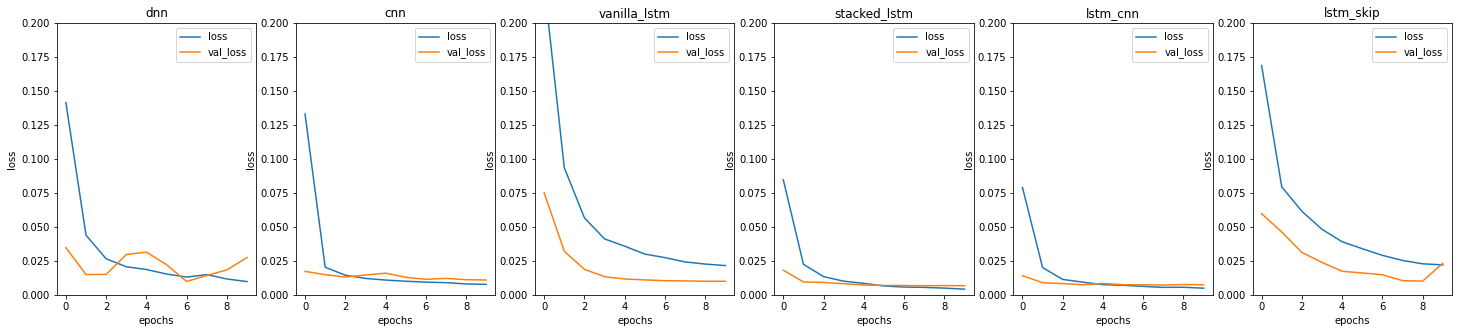

In [ ]:
legend = list()

fig, axs = plt.subplots(1, len(model_configs.items()), figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


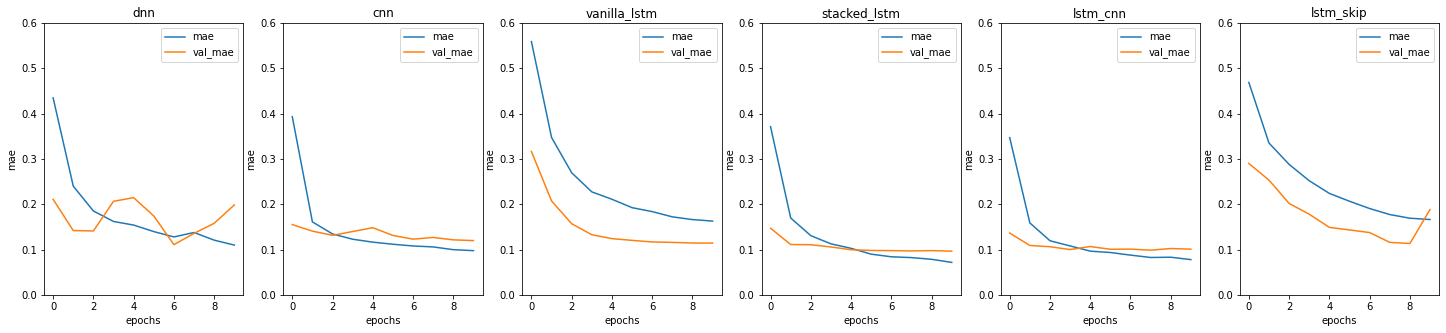

In [ ]:
print("MAE Curves")
fig, axs = plt.subplots(1, len(model_configs.items()), figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

### Performance Plot

In [ ]:
names = list()
performance_dict = {'mae':[],'rmse':[]}


for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance_dict['mae'].append(mae[1])
    performance_dict['rmse'].append(mae[2])

performance_df = pd.DataFrame(data=performance_dict,columns=performance_dict.keys(),index=names)
performance_df['Error in M/S'] = performance_df['mae'] * load_data(['WS50M'], verbose=False).mean().values 
print(performance_df)

4/4 [==============================] - 1s 213ms/step - loss: 0.0169 - mae: 0.1658 - root_mean_squared_error: 0.1837
                   mae      rmse  Error in M/S
dnn           0.059841  0.076988      0.332315
cnn           0.063471  0.081746      0.352472
vanilla_lstm  0.092050  0.116520      0.511182
stacked_lstm  0.046905  0.059203      0.260477
lstm_cnn      0.051615  0.065469      0.286635
lstm_skip     0.165839  0.183711      0.920956


### Prediction Plot

In [ ]:
def performance_metrics(data,y_true,y_pred,days = 2):
    data['mae'].append(mean_absolute_error(y_true.numpy()[:days].reshape(-1), y_pred[:days].reshape(-1)))
    data['mse'].append(mean_squared_error(y_true.numpy()[:days].reshape(-1), y_pred[:days].reshape(-1)))
    data['rmse'].append(np.sqrt(mean_squared_error(y_true.numpy()[:days].reshape(-1), y_pred[:days].reshape(-1))))
    data['mape'].append(np.mean(np.abs((y_true.numpy()[:days].reshape(-1) -  y_pred[:days].reshape(-1)) / y_true.numpy()[:days].reshape(-1))) * 100)
    return data

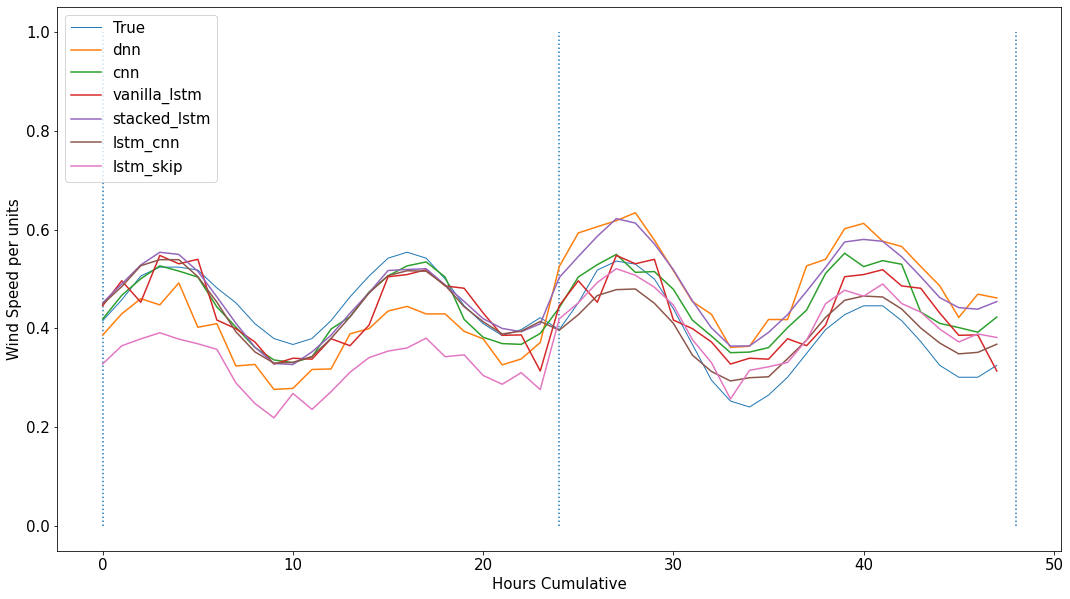

In [ ]:
days =2
wind_speed_data = pd.DataFrame({'True':[]})

plt.figure(figsize=(18,10))
test_data = model_configs['dnn']['test_ds']
_, ybatch = iter(test_data).get_next()
wind_speed_data['True']= ybatch.numpy()[:days].reshape(-1)
vline = np.linspace(0, days*24, days+1)
plt.plot(ybatch.numpy()[:days].reshape(-1), label="True",linewidth = '1')
plt.vlines(vline, ymin=0, ymax=1, linestyle='dotted')
for key,val in model_configs.items():
    preds = val['model'].predict(test_data)
    wind_speed_data = pd.concat([wind_speed_data,pd.Series(preds[:days].reshape(-1)).rename(key)],axis=1)

    plt.plot(preds[:days].reshape(-1),label= key)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel("Hours Cumulative", fontsize=15)
    plt.ylabel("Wind Speed per units", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

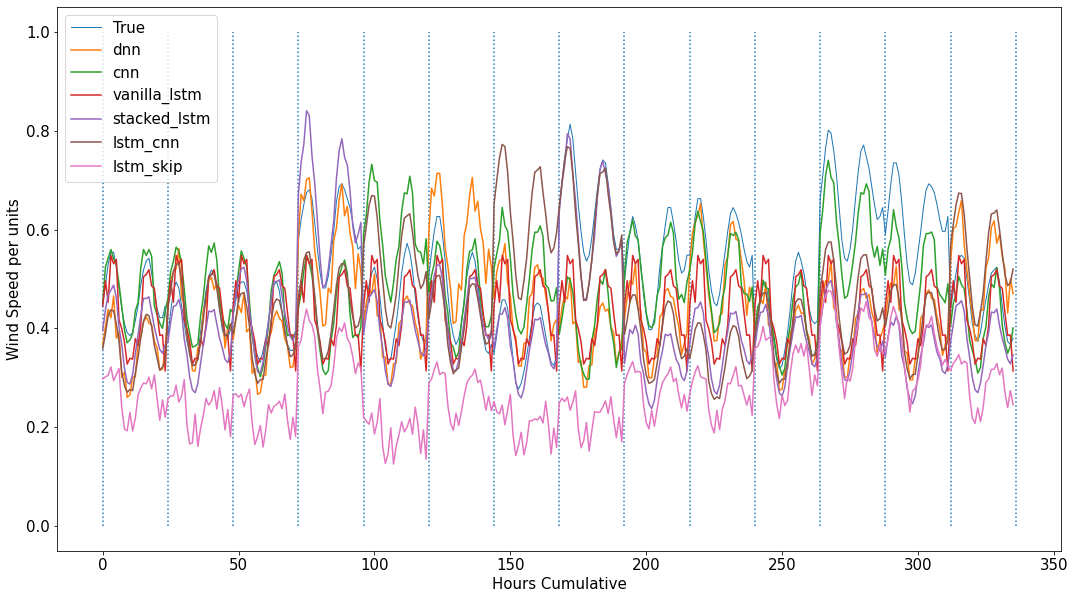

In [ ]:
days =14
wind_speed_data = pd.DataFrame({'True':[]})

plt.figure(figsize=(18,10))
test_data = model_configs['dnn']['test_ds']
_, ybatch = iter(test_data).get_next()
wind_speed_data['True']= ybatch.numpy()[:days].reshape(-1)
vline = np.linspace(0, days*24, days+1)
plt.plot(ybatch.numpy()[:days].reshape(-1), label="True",linewidth = '1')
plt.vlines(vline, ymin=0, ymax=1, linestyle='dotted')
for key,val in model_configs.items():
    preds = val['model'].predict(test_data)
    wind_speed_data = pd.concat([wind_speed_data,pd.Series(preds[:days].reshape(-1)).rename(key)],axis=1)

    plt.plot(preds[:days].reshape(-1),label= key)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel("Hours Cumulative", fontsize=15)
    plt.ylabel("Wind Speed per units", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

In [ ]:
wind_speed_data.head(10).style

,True,dnn,cnn,vanilla_lstm,stacked_lstm,lstm_cnn,lstm_skip
0,0.445783,0.367558,0.451555,0.446127,0.396276,0.358816,0.297895
1,0.487952,0.404422,0.524639,0.496428,0.438050,0.389183,0.301896
2,0.530120,0.438590,0.542337,0.452922,0.468307,0.425726,0.305264
3,0.554217,0.421372,0.559752,0.547695,0.477536,0.437720,0.321907
4,0.554217,0.465788,0.541264,0.530807,0.487530,0.435384,0.294140
5,0.524096,0.380375,0.528846,0.539856,0.462078,0.409420,0.306558
6,0.481928,0.394020,0.489786,0.416927,0.402014,0.373833,0.318758
7,0.439759,0.301432,0.445220,0.399501,0.368015,0.311519,0.239724
8,0.409639,0.311272,0.397239,0.372609,0.319282,0.284364,0.196531
9,0.391566,0.260729,0.371017,0.327862,0.290952,0.270824,0.192661


,mae,rmse,mse,mape
dnn,0.067440,0.095841,0.009185,28.638713
cnn,0.062347,0.084145,0.007080,16.296977
vanilla_lstm,0.073624,0.092308,0.008521,16.502846
stacked_lstm,0.111664,0.138709,0.019240,48.895655
lstm_cnn,0.106299,0.140462,0.019729,30.501576
lstm_skip,0.146470,0.176872,0.031284,32.134617


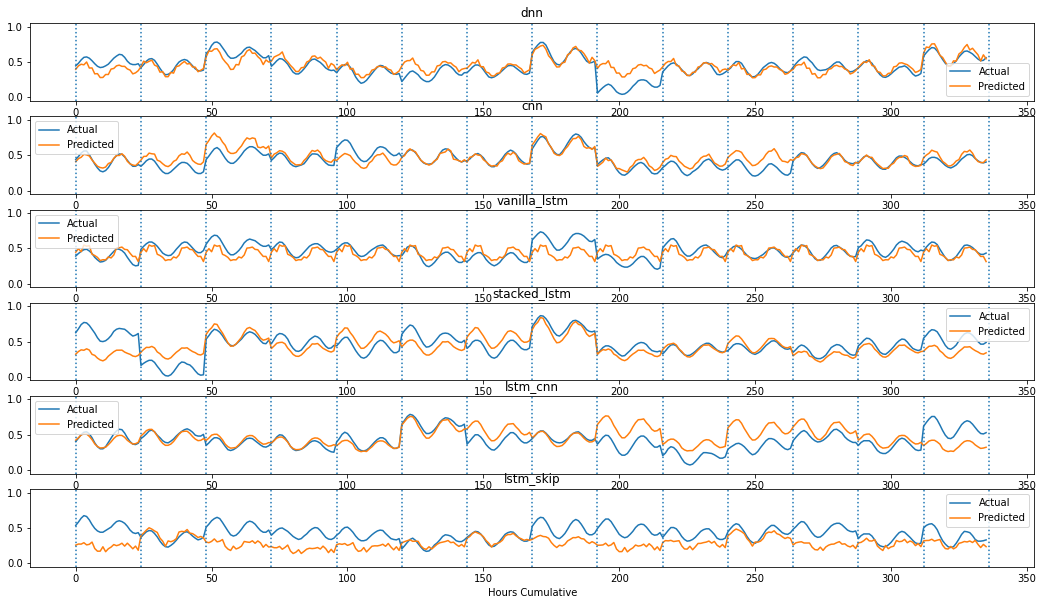

In [ ]:
days = 14
perf_dict = {'mae':[],'rmse':[],'mse':[],'mape':[]}
_, axs = plt.subplots(len(model_configs.items()), 1, figsize=(18, 10))
for (key, val), ax in zip(model_configs.items(), axs):
    test = val['test_ds']
    preds = val['model'].predict(test)
    _, ybatch = iter(test).get_next()
    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])


    perf_dict = performance_metrics(perf_dict,ybatch,preds,days=days)
plt.xlabel("Hours Cumulative")
perf_df = pd.DataFrame(data=perf_dict,columns=perf_dict.keys(),index=names)
perf_df.style

,mae,rmse,mse,mape
dnn,0.212388,0.217003,0.047090,48.747273
cnn,0.045958,0.054951,0.003020,10.347716
vanilla_lstm,0.113584,0.137899,0.019016,19.762134
stacked_lstm,0.187019,0.215736,0.046542,66.224089
lstm_cnn,0.117421,0.119921,0.014381,35.079167
lstm_skip,0.255245,0.278412,0.077514,47.820548


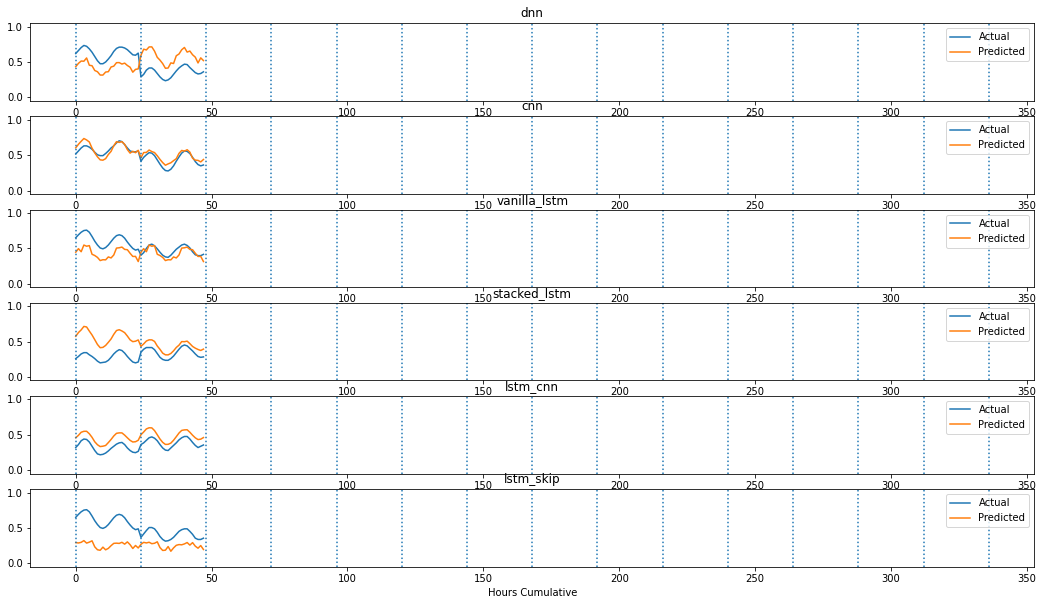

In [ ]:
days = 2
perf_dict = {'mae':[],'rmse':[],'mse':[],'mape':[]}
_, axs = plt.subplots(len(model_configs.items()), 1, figsize=(18, 10))
for (key, val), ax in zip(model_configs.items(), axs):
    test = val['test_ds']
    preds = val['model'].predict(test)
    _, ybatch = iter(test).get_next()
    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])


    perf_dict = performance_metrics(perf_dict,ybatch,preds,days=days)
plt.xlabel("Hours Cumulative")
perf_df = pd.DataFrame(data=perf_dict,columns=perf_dict.keys(),index=names)
perf_df.style

In [ ]:
# lstmskip, cnn
# lstm, dnn
def ensemble_model(model_configs,count = 2):
    ensemble_model_list = [
        ['lstm_skip','stacked_lstm'],
        ['stacked_lstm','lstm_cnn']
    ]
    perf_dict = {'mae':[],'rmse':[],'mse':[],'mape':[]}
    test_model = model_configs['dnn']['test_ds']
    _,y_true = iter(test_model).get_next()

    for i in ensemble_model_list:
        pred_model1 = model_configs[i[0]]['model'].predict(test_model)
        pred_model2 = model_configs[i[1]]['model'].predict(test_model)
        ensemble_pred = (pred_model1+pred_model2) / 2
        perf_dict = performance_metrics(perf_dict,y_true,ensemble_pred,days=count)
        actual_predicted_plot(y_true.numpy()[:count].reshape(-1),  ensemble_pred[:count].reshape(-1))
    perf_df = pd.DataFrame(data=perf_dict,columns=perf_dict.keys(),index=['LSTM-skip and stacked-LSTM','Stacked-LSTM and LSTM-CNN'])
    return perf_df

Ensemble model Plot


,mae,rmse,mse,mape
LSTM-skip and stacked-LSTM,0.194104,0.228132,0.052044,32.250401
Stacked-LSTM and LSTM-CNN,0.131979,0.185892,0.034556,20.445619


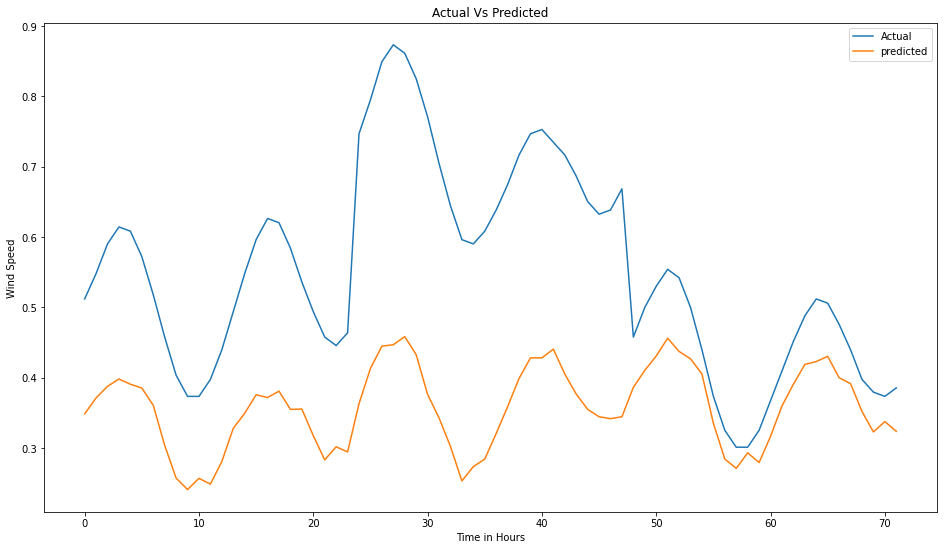

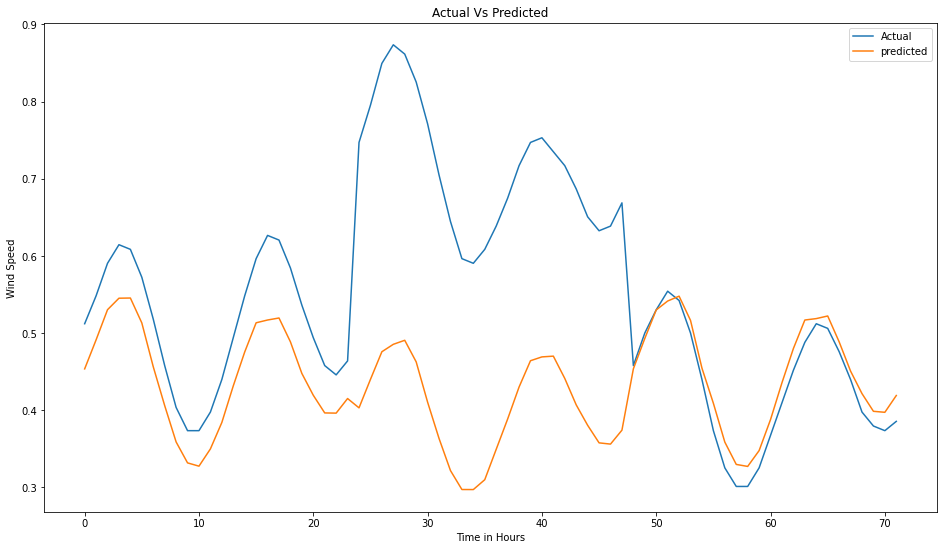

In [ ]:
print('Ensemble model Plot')
ensemble_perf = ensemble_model(model_configs,count=3)
ensemble_perf.style

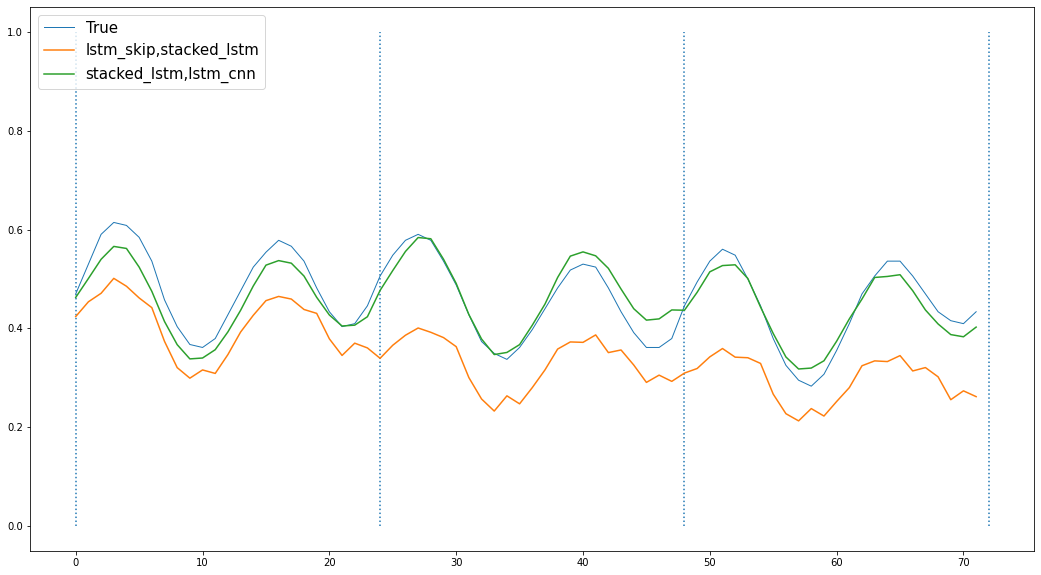

In [ ]:
def ensemble_model_combined_graph(model_configs,count = 2):
    ensemble_model_list = [
        ['lstm_skip','stacked_lstm'],
        ['stacked_lstm','lstm_cnn']
    ]
    perf_dict = {'mae':[],'rmse':[],'mse':[],'mape':[]}
    plt.figure(figsize=(18,10))
    test_model = model_configs['dnn']['test_ds']
    _,y_true = iter(test_model).get_next()
    plt.plot(y_true.numpy()[:count].reshape(-1), label="True",linewidth = '1')
    plt.vlines(np.linspace(0, count*24, count+1), ymin=0, ymax=1, linestyle='dotted')

    for i in ensemble_model_list:
        pred_model1 = model_configs[i[0]]['model'].predict(test_model)
        pred_model2 = model_configs[i[1]]['model'].predict(test_model)
        ensemble_pred = (pred_model1+pred_model2) / 2
        plt.plot(ensemble_pred[:count].reshape(-1),label = ','.join(i))
        plt.legend(loc='upper left', fontsize=15)

ensemble_model_combined_graph(model_configs,count=3)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0f09a2a5-4e9a-4069-8e2b-17fa808f5770' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>